<a href="https://colab.research.google.com/github/yh08037/Introduction-to-Intelligent-Systems/blob/master/HW7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.metrics import confusion_matrix


def get_labels(data):
    y = np.zeros(len(data))
    for i in range(len(y)):
        if data[i, 0] == 'ham':
            y[i] = 0
        elif data[i, 0] == 'spam':
            y[i] = 1
    
    return y


def make_Dictionary(data): 
    all_words = [] 
    x = data[:, 1]
    for i in range(len(data)):
        words = x[i].split() 
        all_words += words
                    
    dictionary = Counter(all_words)
    
    for item in list(dictionary): 
        if item.isalpha() == False: 
            del dictionary[item] 
        elif len(item) == 1: 
            del dictionary[item] 
            
    dictionary = dictionary.most_common(3000) 
    
    return dictionary


def extract_features(data): 
    x = data[:, 1]
    features_matrix = np.zeros((len(data), 3000)) 
    for n in range(len(data)): 
        words = x[n].split() 
        for word in words: 
            wordID = 0 
            for i, d in enumerate(dictionary): 
                if d[0] == word: 
                    wordID = i 
                    if words.count(word) != 0: 
                        features_matrix[n, wordID] = 1
                    else:
                        features_matrix[n, wordID] = 0
    
    return features_matrix


def predict(matrix):
    I, N = matrix.shape 
    y = np.ones(I)
   
    for i in range(I):
        product_0 = 1.
        product_1 = 1.
        for n in range(N):
            if matrix[i, n] == 0:
                product_0 *= (1 - phi_ny0[n])
                product_1 *= (1 - phi_ny1[n])
            else:  
                product_0 *= phi_ny0[n]
                product_1 *= phi_ny1[n]
        
        product_0 *= (1 - phi_y)
        product_1 *= phi_y
        
        if product_0 > product_1:
            y[i] = 0
    
    return y

In [0]:
data_in = np.asarray(pd.read_csv('messages.txt', sep='\t'))

num_train = int(len(data_in) * 0.7)
num_test = len(data_in) - num_train

train_data = data_in[:num_train]
test_data = data_in[-num_test:]


# Create a dictionary of words with its frequency
dictionary = make_Dictionary(train_data)

# Prepare feature vectors per training mail and its labels
train_labels = get_labels(train_data)
train_matrix = extract_features(train_data)

In [5]:
# Training Naive bayes classifier and its variants
alpha = 1

I, N = train_matrix.shape

phi_ny1 = []

for n in range(N):
    sum_x1y1 = 0.
    sum_y1 = 0.
    for i in range(I):
        if train_labels[i] == 1:
            sum_y1 += 1
            if train_matrix[i, n] == 1:
                sum_x1y1 += 1
    phi_ny1.append((sum_x1y1 + alpha) / (sum_y1 + 2 * alpha))


phi_ny0 = []

for n in range(N):
    sum_x1y0 = 0.
    sum_y1 = 0.
    for i in range(I):
        if train_labels[i] == 0:
            sum_y1 += 1
            if train_matrix[i, n] == 1:
                sum_x1y0 += 1
    phi_ny0.append((sum_x1y0 + alpha) / (sum_y1 + 2 * alpha))


phi_y = 0.
for i in range(I):
    if train_labels[i] == 1:
        phi_y += 1

phi_y = (phi_y + alpha) / (I + 2 * alpha)

result = predict(train_matrix)


print(confusion_matrix(train_labels, result))

[[3020   11]
 [  38  428]]


In [0]:
# Test the unseen mails for Spam

test_labels = get_labels(test_data)
test_matrix = extract_features(test_data)

result = predict(test_matrix)

print(confusion_matrix(test_labels, result))

In [26]:
# Training Naive bayes classifier and find optimal value of alpha

# alpha_list = np.arange(0.1, 2.1, 0.1)   # [0.1, 0.2, ... 2.0]
alpha_list = np.asarray([0.0001, 0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 
                         0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.4, 0.6, 0.8, 1])

train_error_list = []
test_error_list = []
    
I, N = train_matrix.shape

for alpha in alpha_list:

    phi_ny1 = []
    
    sum_y1 = 0.
    for i in range(I):
        if train_labels[i] == 1:
            sum_y1 += 1
    
    for n in range(N):
        sum_x1y1 = 0.
        for i in range(I):
            if train_labels[i] == 1 and train_matrix[i, n] == 1:
                sum_x1y1 += 1
        phi_ny1.append((sum_x1y1 + alpha) / (sum_y1 + 2 * alpha))
    
   
    phi_ny0 = []

    sum_y0 = I - sum_y1
    
    for n in range(N):
        sum_x1y0 = 0.
        for i in range(I):
            if train_labels[i] == 0 and train_matrix[i, n] == 1:
                sum_x1y0 += 1
        phi_ny0.append((sum_x1y0 + alpha) / (sum_y0 + 2 * alpha))

    
    phi_y = 0.
    for i in range(I):
        if train_labels[i] == 1:
            phi_y += 1

    phi_y = (phi_y + alpha) / (I + 2 * alpha)
    
    
    result = predict(train_matrix)
    conf_mat = confusion_matrix(train_labels, result)   
    train_error = conf_mat[0, 1] + conf_mat[1, 0]
    
    train_error_list.append(train_error)
    
    print('alpha : %g' %alpha)
    print('training data')
    print(conf_mat, train_error)
    
    # Test the unseen mails for Spam
    result = predict(test_matrix)
    conf_mat = confusion_matrix(test_labels, result)
    test_error = conf_mat[0, 1] + conf_mat[1, 0]
    
    test_error_list.append(test_error)
    
    print('test data')
    print(conf_mat, test_error)
    
    print()
    
#     error_list.append(error)

alpha : 0.0001
training data
[[3028    3]
 [  19  447]] 22
test data
[[1292    2]
 [  34  172]] 36

alpha : 0.001
training data
[[3028    3]
 [  19  447]] 22
test data
[[1292    2]
 [  33  173]] 35

alpha : 0.01
training data
[[3027    4]
 [  20  446]] 24
test data
[[1292    2]
 [  29  177]] 31

alpha : 0.02
training data
[[3027    4]
 [  20  446]] 24
test data
[[1292    2]
 [  27  179]] 29

alpha : 0.03
training data
[[3026    5]
 [  20  446]] 25
test data
[[1292    2]
 [  25  181]] 27

alpha : 0.04
training data
[[3026    5]
 [  20  446]] 25
test data
[[1292    2]
 [  25  181]] 27

alpha : 0.05
training data
[[3026    5]
 [  20  446]] 25
test data
[[1292    2]
 [  24  182]] 26

alpha : 0.06
training data
[[3024    7]
 [  21  445]] 28
test data
[[1289    5]
 [  25  181]] 30

alpha : 0.07
training data
[[3023    8]
 [  21  445]] 29
test data
[[1289    5]
 [  25  181]] 30

alpha : 0.08
training data
[[3024    7]
 [  21  445]] 28
test data
[[1290    4]
 [  26  180]] 30

alpha : 0.09
trai

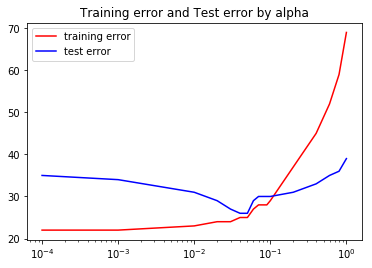

In [34]:
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter1d


plt.title('Training error and Test error by alpha')

plt.xscale('log')

train_error_smoothed = gaussian_filter1d(train_error_list, sigma=0.2)
test_error_smoothed = gaussian_filter1d(test_error_list, sigma=0.2)

plt.plot(alpha_list, train_error_smoothed, 'r', label = 'training error')
plt.plot(alpha_list, test_error_smoothed, 'b', label = 'test error')

plt.legend()

plt.show()